# Data block foundations

In [ ]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/FastaiNotebook_07_batchnorm")' FastaiNotebook_07_batchnorm

Installing packages:
	.package(path: "/home/ubuntu/fastai_docs/dev_swift/FastaiNotebook_07_batchnorm")
		FastaiNotebook_07_batchnorm
With SwiftPM flags: []
Working in: /tmp/tmprsskhcs6/swift-install
Compile Swift Module 'jupyterInstalledPackages' (1 sources)
Initializing Swift...
Installation complete!


In [ ]:
//export
import Path
import TensorFlow
import Python

In [ ]:
import FastaiNotebook_07_batchnorm

In [ ]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


## Image ItemList

### Download Imagenette

First things first, we need to download Imagenette and untar it. What follows is very close to what we did for MNIST.

In [ ]:
//export
public let dataPath = Path.home/".fastai"/"data"

In [ ]:
//export
public func downloadImagette(path: Path = dataPath) -> Path {
    let url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette-160.tgz"
    let fname = "imagenette-160"
    let file = path/fname
    try! path.mkdir(.p)
    if !file.exists {
        downloadFile(url, dest:(path/"\(fname).tgz").string)
        _ = shellCommand("/bin/tar", ["-xzf", (path/"\(fname).tgz").string, "-C", path.string])
    }
    return file
}

In [ ]:
let path = downloadImagette()

If we look at `path.ls()`, we see it returns a list of entries, which are structures with a `kind` and a `path` attribute. The `kind` is an enum that can be `file` or `directory`. `path` then points to the corresponding location.

In [ ]:
for e in path.ls() { print("\(e.path) (\(e.kind == .directory ? "directory": "file"))")}

/home/ubuntu/.fastai/data/imagenette-160/val (directory)
/home/ubuntu/.fastai/data/imagenette-160/train (directory)
/home/ubuntu/.fastai/data/imagenette-160/models (directory)


In [ ]:
for e in (path/"val").ls() { print("\(e.path) (\(e.kind == .directory ? "directory": "file"))")}

/home/ubuntu/.fastai/data/imagenette-160/val/n03888257 (directory)
/home/ubuntu/.fastai/data/imagenette-160/val/n03445777 (directory)
/home/ubuntu/.fastai/data/imagenette-160/val/n03425413 (directory)
/home/ubuntu/.fastai/data/imagenette-160/val/n01440764 (directory)
/home/ubuntu/.fastai/data/imagenette-160/val/n03028079 (directory)
/home/ubuntu/.fastai/data/imagenette-160/val/n02979186 (directory)
/home/ubuntu/.fastai/data/imagenette-160/val/n03394916 (directory)
/home/ubuntu/.fastai/data/imagenette-160/val/n02102040 (directory)
/home/ubuntu/.fastai/data/imagenette-160/val/n03417042 (directory)
/home/ubuntu/.fastai/data/imagenette-160/val/n03000684 (directory)


Let's have a look inside a class folder (the first class is tench):

In [ ]:
let pathTench = path/"val"/"n01440764"

In [ ]:
let imgFn = Path.home/".fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00006697.JPEG"
imgFn.string

"/home/ubuntu/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00006697.JPEG"


We will use `tf.data` to read and resize our images in parallel. `tf.data` needs to operate on tensors, so we convert our `Path` image filename to that format. We can then apply the extensions that we defined previously in 01.

In [ ]:
let decodedImg = StringTensor(readFile: imgFn.string).decodeJpeg(channels: 3)

In [ ]:
print(decodedImg.shape)

TensorShape(dimensions: [160, 213, 3])


By converting this image to numpy, we can use `plt` to plot it:

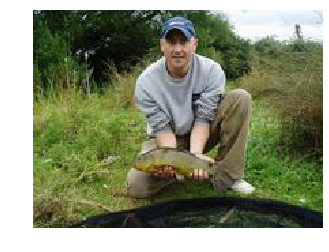

None


In [ ]:
let numpyImg = decodedImg.makeNumpyArray()
plt.imshow(numpyImg) 
plt.axis("off")
plt.show()

### Grab all the images

Now that we have donloaded the data, we need to be able to recursively grab all the filenames in the imagenette folder. The following function walks recursively through the folder and adds the filenames that have the right extension.

In [ ]:
//export
public func fetchFiles(path: Path, recurse: Bool = false, extensions: [String]? = nil) -> [Path] {
    var res: [Path] = []
    for p in try! path.ls(){
        if p.kind == .directory && recurse { 
            res += fetchFiles(path: p.path, recurse: recurse, extensions: extensions)
        } else if extensions == nil || extensions!.contains(p.path.extension.lowercased) {
            res.append(p.path)
        }
    }
    return res
}

Note that we don't have a generic `open_image` function like in python here, but will be using a specific decode function (here for jpegs, but there is one for gifs or pngs). That's why we limit ourselves to jpeg exensions here.

In [ ]:
time { let fNames = fetchFiles(path: path, recurse: true, extensions: ["jpeg", "jpg"]) }

average: 1102.471384 ms,   min: 1102.471384 ms,   max: 1102.471384 ms


In [ ]:
let fNames = fetchFiles(path: path, recurse: true, extensions: ["jpeg", "jpg"])

In [ ]:
fNames.count == 13394

true


## Prepare the data

`Dataset` can handle all the transforms that go on a `Tensor`, including opening an image and resizing it since it takes `StringTensor`. That makes the `tfms` attribute of `ItemList` irrelevant, so `ItemList` is just an array of `Item` with a path (if get method seems useful later, we can add it).

In [ ]:
// export
public struct ItemList<Item>{
    public var items: [Item]
    public let path: Path
    
    public init(items: [Item], path: Path){
        (self.items,self.path) = (items,path)
    }
}

In [ ]:
// export
public extension ItemList where Item == Path {
    init(fromFolder path: Path, extensions: [String], recurse: Bool = true) {
        self.init(items: fetchFiles(path: path, recurse: recurse, extensions: extensions),
                  path:  path)
    }
}

In [ ]:
let il = ItemList(fromFolder: path, extensions: ["jpeg", "jpg"])

### Split

In [ ]:
// export
public struct SplitData<Item>{
    public let train: ItemList<Item>
    public let valid: ItemList<Item>
    public var path: Path { return train.path }
    
    public init(train: ItemList<Item>, valid: ItemList<Item>){
        (self.train, self.valid) = (train, valid)
    }
    
    public init(_ il: ItemList<Item>, fromFunc: (Item) -> Bool){
        var (trn, val): ([Item], [Item]) = ([], [])
        for x in il.items {
            if fromFunc(x) { val.append(x) }
            else           { trn.append(x) }
        }
        self.init(train: ItemList(items: trn, path: il.path),
                  valid: ItemList(items: val, path: il.path))
    }
}

In [ ]:
// export
public func grandParentSplitter(fName: Path, valid: String = "valid") -> Bool{
    return fName.parent.parent.basename() == valid
}

In [ ]:
let sd = SplitData(il) { grandParentSplitter(fName: $0, valid: "val") }

### Processor

In [ ]:
// export
public protocol Processor {
    associatedtype Input
    associatedtype Output
    
    mutating func initState(items: [Input])
    func process1(item: Input) -> Output
    func deprocess1(item: Output) -> Input
}

In [ ]:
// export
public extension Processor {
    func process(items: [Input]) -> [Output] {
        return items.map { process1(item: $0) }
    }
    
    func deprocess(items: [Output]) -> [Input] {
        return items.map { deprocess1(item: $0) }
    }
}

In [ ]:
// export
public struct NoopProcessor<Item>: Processor {
    public init() {}
   
    public mutating func initState(items: [Item]) {}
    
    public func process1  (item: Item) -> Item { return item }
    public func deprocess1(item: Item) -> Item { return item }
}

In [ ]:
// export
public struct CategoryProcessor: Processor {
    public init() {}
    public var vocab: [String]? = nil
    public var reverseMap: [String: Int32]? = nil
    
    public mutating func initState(items: [String]) {
        vocab = Array(Set(items)).sorted()
        reverseMap = [:]
        for (i,x) in vocab!.enumerated() { reverseMap![x] = Int32(i) }
    }
    
    public func process1  (item: String) -> Int32 { return reverseMap![item]! }
    public func deprocess1(item: Int32)  -> String { return vocab![Int(item)] }
}

### Label

When we build the datasets, we don't need to return a tupe (item, label) but to have the tensor(s) with the items and the tensor(s) with the labels separately.

In [ ]:
//export
public struct LabeledItemList<PI,PL> where PI: Processor, PL: Processor{
    public var items: [PI.Output]
    public var labels: [PL.Output]
    public let path: Path
    public var procItem: PI
    public var procLabel: PL
    
    public init(rawItems: [PI.Input], rawLabels: [PL.Input], path: Path, procItem: PI, procLabel: PL){
        (self.procItem,self.procLabel,self.path) = (procItem,procLabel,path)
        self.items = procItem.process(items: rawItems)
        self.labels = procLabel.process(items: rawLabels)
    }
    
    public init(_ il: ItemList<PI.Input>, fromFunc: (PI.Input) -> PL.Input, procItem: PI, procLabel: PL){
        self.init(rawItems:  il.items,
                  rawLabels: il.items.map{ fromFunc($0)},
                  path:      il.path,
                  procItem:  procItem,
                  procLabel: procLabel)
    }
    
    public func rawItem (_ idx: Int) -> PI.Input { return procItem.deprocess1 (item: items[idx])  }
    public func rawLabel(_ idx: Int) -> PL.Input { return procLabel.deprocess1(item: labels[idx]) }
}

In [ ]:
//export
public struct SplitLabeledData<PI,PL> where PI: Processor, PL: Processor{
    public let train: LabeledItemList<PI,PL>
    public let valid: LabeledItemList<PI,PL>
    public var path: Path { return train.path }
    
    public init(train: LabeledItemList<PI,PL>, valid: LabeledItemList<PI,PL>){
        (self.train, self.valid) = (train, valid)
    }
    
    public init(_ sd: SplitData<PI.Input>, fromFunc: (PI.Input) -> PL.Input, procItem: inout PI, procLabel: inout PL){
        procItem.initState (items: sd.train.items)
        let trainLabels = sd.train.items.map{ fromFunc($0) }
        procLabel.initState(items: trainLabels)
        self.init(train: LabeledItemList(rawItems: sd.train.items, rawLabels: trainLabels, path: sd.path, 
                                         procItem: procItem, procLabel: procLabel),
                  valid: LabeledItemList(sd.valid, fromFunc: fromFunc, procItem: procItem, procLabel: procLabel))
    }
}

In [ ]:
//export
public func parentLabeler(_ fName: Path) -> String { return fName.parent.basename() }

In [ ]:
var (procItem,procLabel) = (NoopProcessor<Path>(),CategoryProcessor())
let sld = SplitLabeledData(sd, fromFunc: parentLabeler, procItem: &procItem, procLabel: &procLabel)

In [ ]:
print(sld.train.labels[0])
print(sld.train.rawLabel(0))
print(sld.train.procLabel.vocab!)

9
n03888257
["n01440764", "n02102040", "n02979186", "n03000684", "n03028079", "n03394916", "n03417042", "n03425413", "n03445777", "n03888257"]


### Datasets

To go in a Dataset, our array of items and array of labels need to be converted to tensors.

In [ ]:
// export
public struct LabeledElement<I: TensorGroup, L: TensorGroup>: TensorGroup {
    public var xb: I
    public var yb: L    
    
    public init(xb: I, yb: L) {
        (self.xb, self.yb) = (xb, yb)
    }
}

In [ ]:
// export
public extension SplitLabeledData {
    func toDataBunch<XB, YB> (
        itemToTensor: ([PI.Output]) -> XB, labelToTensor: ([PL.Output]) -> YB, bs: Int = 64
    ) -> DataBunch<LabeledElement<XB, YB>> where XB: TensorGroup, YB: TensorGroup {
        let trainDs = Dataset<LabeledElement<XB, YB>>(
            elements: LabeledElement(xb: itemToTensor(train.items), yb: labelToTensor(train.labels)))
        let validDs = Dataset<LabeledElement<XB, YB>>(
            elements: LabeledElement(xb: itemToTensor(valid.items), yb: labelToTensor(valid.labels)))
        return DataBunch(train: trainDs, 
                         valid: validDs, 
                         trainLen: train.items.count, 
                         validLen: valid.items.count,
                         bs: bs)
    }
}

In [ ]:
// export
public func pathsToTensor(_ paths: [Path]) -> StringTensor { return StringTensor(paths.map{ $0.string })}
public func intsToTensor(_ items: [Int32]) -> Tensor<Int32> { return Tensor<Int32>(items)}

In [ ]:
let dataset = sld.toDataBunch(itemToTensor: pathsToTensor, labelToTensor: intsToTensor)

### Transforms

We directly plug in to the dataset the transforms we want to apply.

In [ ]:
// export
public func transformData<I,TI,L>(
    _ data: DataBunch<LabeledElement<I,L>>, 
    tfmItem: (I) -> TI
) -> DataBunch<DataBatch<TI,L>> 
where I: TensorGroup, TI: TensorGroup & Differentiable, L: TensorGroup{
    return DataBunch(train: data.train.innerDs.map{ DataBatch(xb: tfmItem($0.xb), yb: $0.yb) },
                     valid: data.valid.innerDs.map{ DataBatch(xb: tfmItem($0.xb), yb: $0.yb) },
                     trainLen: data.train.dsCount, 
                     validLen: data.valid.dsCount,
                     bs: data.train.bs)
}

In [ ]:
// export
public func openAndResize(fname: StringTensor, size: Int) -> TF{
    let decodedImg = StringTensor(readFile: fname).decodeJpeg(channels: 3)
    let resizedImg = Tensor<Float>(Raw.resizeNearestNeighbor(
        images: Tensor<UInt8>([decodedImg]), 
        size: Tensor<Int32>([Int32(size), Int32(size)]))) / 255.0
    return resizedImg.reshaped(to: TensorShape(size, size, 3))
}

In [ ]:
let tfmData = transformData(dataset) { openAndResize(fname: $0, size: 128) }

In [ ]:
// export
public extension FADataset {
    func oneBatch() -> Element? {
        for batch in ds { return batch }
        return nil
    }
} 

In [ ]:
let batch = tfmData.train.oneBatch()!
batch.xb.shape

▿ TensorShape
  ▿ dimensions : 4 elements
    - 0 : 64
    - 1 : 128
    - 2 : 128
    - 3 : 3


In [ ]:
// export
public func showImages(_ xb: TF, labels: [String]? = nil) {
    let (rows,cols) = (3,3)
    plt.figure(figsize: [9, 9])
    for i in 0..<(rows * cols) {
        let img = plt.subplot(rows, cols, i + 1)
        img.axis("off")
        let x = xb[i].makeNumpyArray()
        img.imshow(x)
        if labels != nil { img.set_title(labels![i]) }
        if (i + 1) >= (rows * cols) { break }
    }
    plt.show()
}

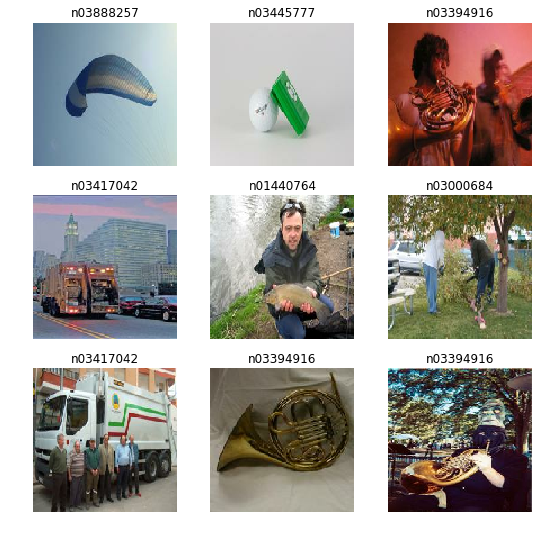

In [ ]:
let labels = batch.yb.scalars.map { sld.train.procLabel.vocab![Int($0)] }
showImages(batch.xb, labels: labels)

### To summarize:

In [ ]:
let il = ItemList(fromFolder: path, extensions: ["jpeg", "jpg"])
let sd = SplitData(il, fromFunc: {grandParentSplitter(fName: $0, valid: "val")})
var (procItem,procLabel) = (NoopProcessor<Path>(), CategoryProcessor())
let sld = SplitLabeledData(sd, fromFunc: parentLabeler, procItem: &procItem, procLabel: &procLabel)
var rawData = sld.toDataBunch(itemToTensor: pathsToTensor, labelToTensor: intsToTensor)
let data = transformData(rawData) { openAndResize(fname: $0, size: 128) }

Let's try to train it:

In [ ]:
//export 
public let imagenetStats = (mean: TF([0.485, 0.456, 0.406]), std: TF([0.229, 0.224, 0.225]))

In [ ]:
//export
public func prevPow2(_ x: Int) -> Int { 
    var res = 1
    while res <= x { res *= 2 }
    return res / 2
}

In [ ]:
//export
public struct CNNModel: Layer {
    public var convs: [ConvBN<Float>]
    public var pool = FAGlobalAvgPool2D<Float>()
    public var linear: FADense<Float>
    
    public init(channelIn: Int, nOut: Int, filters: [Int]){
        convs = []
        let (l1,l2) = (channelIn, prevPow2(channelIn * 9))
        convs = [ConvBN(l1,   l2,   stride: 1),
                 ConvBN(l2,   l2*2, stride: 2),
                 ConvBN(l2*2, l2*4, stride: 2)]
        let allFilters = [l2*4] + filters
        for i in 0..<filters.count { convs.append(ConvBN(allFilters[i], allFilters[i+1], stride: 2)) }
        linear = FADense<Float>(filters.last!, nOut)
    }
    
    @differentiable
    public func call(_ input: TF) -> TF {
        return input.sequenced(through: convs, pool, linear)
    }
}

In [ ]:
func optFunc(_ model: CNNModel) -> SGD<CNNModel> { return SGD(for: model, learningRate: 0.1) }
func modelInit() -> CNNModel { return CNNModel(channelIn: 3, nOut: 10, filters: [64, 64, 128, 256]) }
let learner = Learner(data: data, lossFunc: softmaxCrossEntropy, optFunc: optFunc, modelInit: modelInit)
let recorder = learner.makeDefaultDelegates(metrics: [accuracy])
learner.addDelegate(learner.makeNormalize(mean: imagenetStats.mean, std: imagenetStats.std))

In [ ]:
learner.fit(1)

Epoch 0: [1.3150663, 0.548]                                                     


## Export

In [ ]:
notebookToScript(fname: Path.cwd / "08_data_block.ipynb")